# [Python Project] Part 2 - Data Analysis and Visualization

## 1. Load the libraries

In [1]:
# -*- coding: utf-8 -*-

import glob # find all the pathnames matching a specified pattern 
import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateparser # parse localized dates in almost any string formats
import statsmodels.api as sm # for linear regression

C:\Users\kimi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Set the directory 

print("Directory before : ", os.getcwd()) # check the current directory
os.chdir("C:/Users/kimi/Desktop/IMSD/Cours/Python/projet") # change the directory

print("Directory after : ", os.getcwd())

Directory before :  C:\Users\kimi\Documents\Data_Analysis\Cours de Python
Directory after :  C:\Users\kimi\Desktop\IMSD\Cours\Python\projet


In [3]:
## Merge all the csv files while getting rid of duplicates

csv_files = glob.glob("../data/*.csv") # find all the csv files in data directory
df = pd.concat((pd.read_csv(f, encoding = "utf-8-sig", engine= "python") for f in csv_files)) # concatenate all the csv files in one csv file
df_deduplicated = df.drop_duplicates() # drop the duplicated rows

save_path = "C:/Users/kimi/Desktop/IMSD/Cours/Python/data/" 
df_deduplicated.to_csv(save_path+"merged_data.csv", sep=',', encoding= "utf-8-sig" , index=False) # wirte one combined csv file


## 2. Load the dataset

In [4]:
data_path = "../data/merged_data.csv"
data = pd.read_csv(data_path, encoding = "utf-8-sig", engine= "python")  # important to have "utf-8-sig" encoding in order to keep french charactors with accent such as é, à, ç, etc.

data.head()

,book_names,author_names,editor_names,collections,publication_dates,page_numbers,stars_counts,comments_counts,prices_new
0,Demain,Guillaume MUSSO,Pocket,BEST,5 janvier 2017,544.0,4.4,538,8.1
1,"Désolée, je suis attendue",Agnès MARTIN-LUGAND,Pocket,BEST,6 avril 2017,416.0,4.1,245,7.5
2,Belle du Seigneur,Albert Cohen,Gallimard,Folio,12 février 1998,1109.0,4.1,115,12.6
3,Tous les matins du monde,Pascal Quignard,Gallimard,Folio,16 novembre 1993,116.0,3.9,28,6.6
4,La cicatrice,Bruce Lowery,J'AI LU,LITTERATURE GENERALE,21 octobre 1999,125.0,4.3,41,4.0


In [5]:
# Glimpse at the dataset

print("Data shape: ", data.shape, "\n")  # 1125 observation X 9 columns

print("--------------- Data Type ---------------")
data.info() # 5 variables in object dtype, 3 in float64 dtype, and 1 in int64 dtype
print("\n")

print("----- Missing Values -----", "\n", data.isnull().sum()) # 17 in collections and 5 in page numbers

Data shape:  (1125, 9) 

--------------- Data Type ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 9 columns):
book_names           1125 non-null object
author_names         1125 non-null object
editor_names         1125 non-null object
collections          1108 non-null object
publication_dates    1125 non-null object
page_numbers         1120 non-null float64
stars_counts         1125 non-null float64
comments_counts      1125 non-null int64
prices_new           1125 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 79.2+ KB


----- Missing Values ----- 
 book_names            0
author_names          0
editor_names          0
collections          17
publication_dates     0
page_numbers          5
stars_counts          0
comments_counts       0
prices_new            0
dtype: int64


## 3. Data Cleaning

### 3.1 Missing values

In [6]:
# 3.1.1 For continuous variable: 'page_numbers'

print("Missing values before: ", data['page_numbers'].isnull().sum(), '\n')  # count the missing values : 5 missing values

mean_pages = round(np.mean(data['page_numbers']))  # replace the NaN value by mean 
nan_rows = data[data['page_numbers'].isnull()]
print(nan_rows, '\n')  # check other columns in order to see if there is any particular characteristics among the books which has no page info

data['page_numbers'].fillna(mean_pages, inplace=True) # fill the NaN value with the mean value of 'page_numbers'
print("Missing values after: ", data['page_numbers'].isnull().sum()) # check if the missing value has been filled


Missing values before:  5 

             book_names         author_names        editor_names  \
308  Lettres avec Elise       Patrick Duquoc   Accents poétiques   
341  L'abbaye aux loups       Paul Couturiau   Editions De Borée   
362          Sécheresse     Saint-John Perse               Babel   
688             Paroles      Jacques Prévert  Editions Gallimard   
944        Quelle Nuit!  Galton R/Antrobus J         Avant Scene   

          collections publication_dates  page_numbers  stars_counts  \
308               NaN   15 octobre 2018           NaN           0.0   
341  Roman historique   19 octobre 2017           NaN           4.4   
362               NaN              2000           NaN           0.0   
688             Folio   4 novembre 2016           NaN           3.9   
944   REVUE L'AVANT-S    1 janvier 1992           NaN           0.0   

     comments_counts  prices_new  
308                0        14.0  
341                6         8.5  
362                0        10.

In [7]:
## 3.1.2 For categorical variables: 'collection_names'

# Normally, the missing value in categorical variable is replaced by the most frequent value, however, 
# in our data, this info is being missed because there is simply no collection info for specific books.
# Therefore, we will replace them with "no collection"

print("Missing values before: ", data['collections'].isnull().sum()) # count the missing values : 17 missing values
no_collection = "no collection"

data['collections'].fillna(no_collection, inplace =  True) # replace the NaN value with "no collection"
print("Missing values after: ", data['collections'].isnull().sum())


Missing values before:  17
Missing values after:  0


### 3.2 feature conversion

In [8]:
# 3.2.1 String to datetime: 'publication_dates'

pulication_dates_parsed = []
for date in data['publication_dates']:
    date_parsed = dateparser.parse(date, settings={'PREFER_DAY_OF_MONTH': 'first'}) # if there is no day info, par defaul it takes 1st of the month 
    pulication_dates_parsed.append(date_parsed)
    
data['publication_datetime'] = pulication_dates_parsed # add a new column 'publication_datetime'
pd.to_datetime(data['publication_datetime']) # convert the data type from string to datetime
data.drop(['publication_dates'], inplace=True, axis=1) # drop the old column 

In [9]:
# 3.2.2 Float to int: 'page_numbers'

data['page_numbers'] = data['page_numbers'].astype('int64')  
# if there is a missing value in numeric variable, the type cannot be converted in int64 (NaN value is considered as float)
# therefore, note that the missing value should be treated before the feature conversion. 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 9 columns):
book_names              1125 non-null object
author_names            1125 non-null object
editor_names            1125 non-null object
collections             1125 non-null object
page_numbers            1125 non-null int64
stars_counts            1125 non-null float64
comments_counts         1125 non-null int64
prices_new              1125 non-null float64
publication_datetime    1125 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 79.2+ KB


In [10]:
## 3.2.3 charactor variables: 'book_names', 'author_names', 'editor_names', 'collections'

# In order to group the same name of book names, author names, editor names or collections, 
# All the characctors should be lowercased. 

data['book_names'] = data['book_names'].str.lower() # 'str' allows to lowercase the string 
data['author_names'] = data['author_names'].str.lower()
data['editor_names'] = data['editor_names'].str.lower()
data['collections'] = data['collections'].str.lower()
 
data.tail()

,book_names,author_names,editor_names,collections,page_numbers,stars_counts,comments_counts,prices_new,publication_datetime
1120,contes du jour et de la nuit,guy de maupassant,le livre de poche,classiques,186,4.3,23,3.7,1988-05-01
1121,"le comte de monte-cristo, tome 1",alexandre dumas,gallimard,folio classique,703,4.4,115,8.3,1998-08-26
1122,"du bonheur, un voyage philosophique",frédéric lenoir,le livre de poche,documents,240,4.4,126,6.9,2015-08-26
1123,les croix de bois,roland dorgelès,librairie générale française,le livre de poche,283,4.2,49,5.9,2010-09-08
1124,votre cerveau n'a pas fini de vous étonner,collectif,le livre de poche,documents,240,4.5,97,6.9,2014-09-10


## 4. EDA (Explorary Data Analysis)

### 4.1 Univariate Analysis - continuous variables

### 4.1.1 Central tendency

In [11]:
data.describe()

,page_numbers,stars_counts,comments_counts,prices_new
count,1125.000000,1125.000000,1125.000000,1125.000000
mean,321.100444,3.964267,62.456889,6.851280
std,197.768534,0.800847,109.170274,3.049983
min,16.000000,0.000000,0.000000,1.500000
25%,186.000000,3.800000,11.000000,5.500000
50%,275.000000,4.100000,26.000000,6.950000
75%,416.000000,4.300000,65.000000,8.000000
max,1691.000000,5.000000,1290.000000,62.500000


### 4.1.2 Histogram 1 - basic

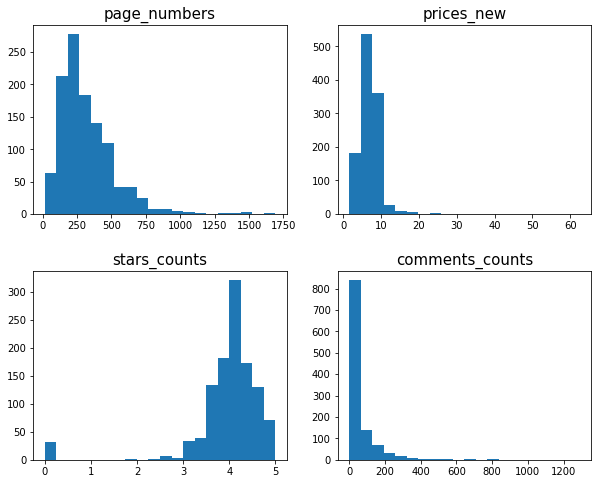

In [12]:
cont = ['page_numbers', 'prices_new', 'stars_counts', 'comments_counts']

cnt=0
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=0.3)
for i in cont:
    cnt += 1
    plt.subplot(2, 2, cnt) # to make four histograms in one frame
    plt.hist(data[i], bins=20) # having 20 bins
    plt.title(i, size=15)
plt.show()


### 4.1.2 Histogram 2 - seaborn dist() plot

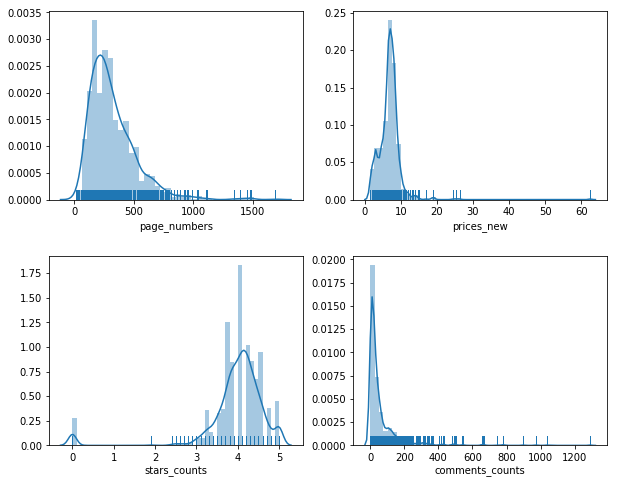

In [13]:
cnt=0
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=0.3)
for i in cont:
    cnt += 1
    plt.subplot(2, 2, cnt) # to make four histograms in one frame
    sns.distplot(data[i], kde=True, rug=True) # rugplot & gaussian kernel density estimate
plt.show()


### 4.1.3 Boxplot

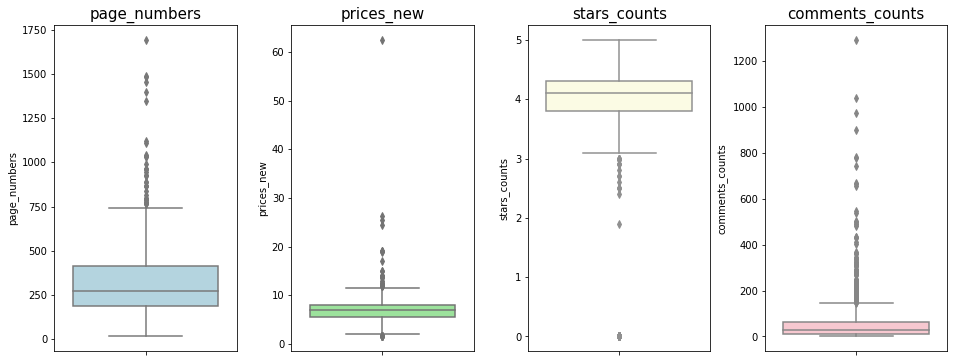

In [14]:
colors = ['lightblue', 'lightgreen', 'lightyellow', 'pink']

cnt = 0
plt.figure(figsize=(16, 6)).subplots_adjust(hspace=0.4, wspace=0.3)
for i in cont:
    cnt += 1
    plt.subplot(1, 4, cnt)
    sns.boxplot(y=data[i], color=colors[cnt-1]) # because cnt starts from 1 and index of list 'colors' starts from 0
    plt.title(i, size = 15)
plt.show()


### 4.1.4 Violinplot

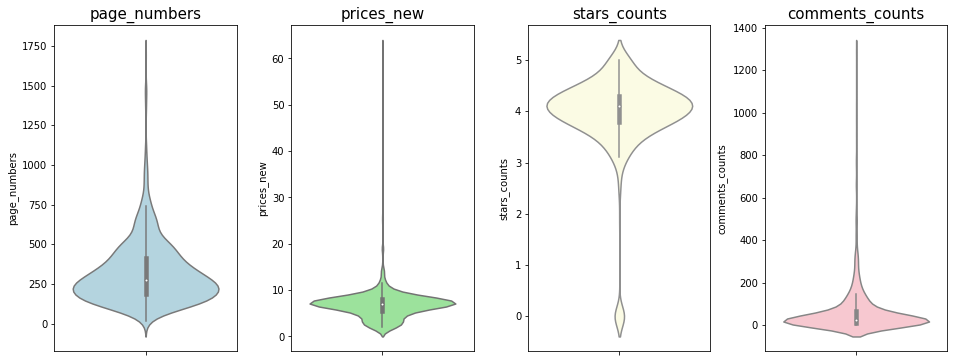

In [15]:
cnt = 0
plt.figure(figsize=(16, 6)).subplots_adjust(hspace=0.4, wspace=0.3)
for i in cont:
    cnt += 1
    plt.subplot(1, 4, cnt)
    sns.violinplot(y=data[i], color=colors[cnt-1])
    plt.title(i, size = 15)
plt.show()


### 4.2 Univariate Analysis - categorical variables

### 4.2.1 Unique values

In [16]:
# by counting the frequency of unique values in categorical variables, 
# we can understand how many categories exist in each categorical variable

print("Unique value of 'book_name' : ", len(data['book_names'].unique())) # 1089 out of 1125
print("Unique value of 'author_names' : ",len(data['author_names'].unique())) # 521 out of 1125
print("Unique value of 'editor_names' : ", len(data['editor_names'].unique())) # 92 out of 1125
print("Unique value of 'collections' : ", len(data['collections'].unique())) # 144 out of 1125

Unique value of 'book_name' :  1089
Unique value of 'author_names' :  551
Unique value of 'editor_names' :  92
Unique value of 'collections' :  144


### 4.2.2 Countplot/barplot

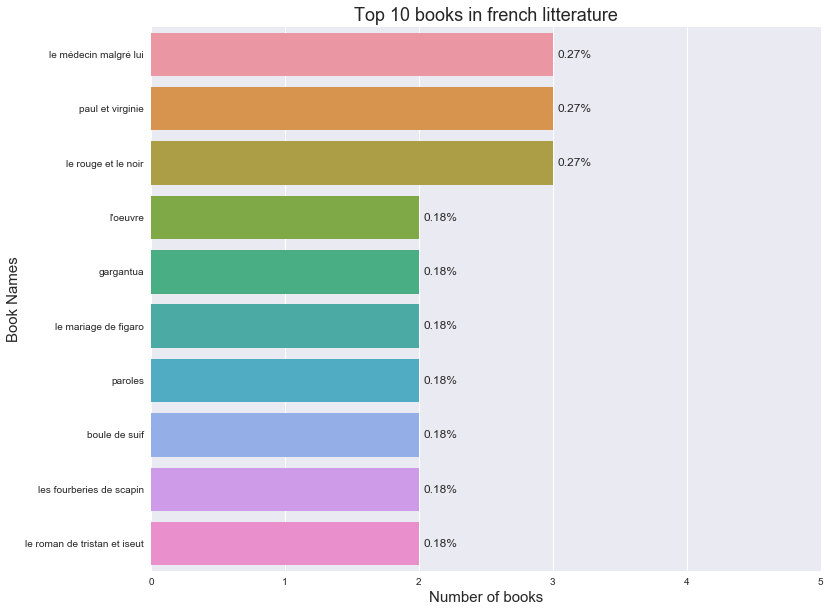

In [17]:
# top 10 books

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")
ax = sns.countplot(y = 'book_names',
                   data = data,
                   order = pd.value_counts(data['book_names']).iloc[:10].index) # first 10 most frequently occurring values

for p in ax.patches:
    width = int(p.get_width()) # to get the width of the rectangles
    ax.annotate('{:.2f}%'.format((width/1125)*100), # to have percentage, we divide the number of value by total value(1125)
                ((p.get_x() + p.get_width()), p.get_y()), 
                xytext=(5, -25), # location of the text
                fontsize=12,
                textcoords='offset points') # place the annotations next to their respective bars

plt.xlim(0, 5) # limit the range of x axis
plt.ylabel("Book Names", size = 15)
plt.xlabel("Number of books", size = 15)
plt.title('Top 10 books in french litterature', size = 18)
plt.show()


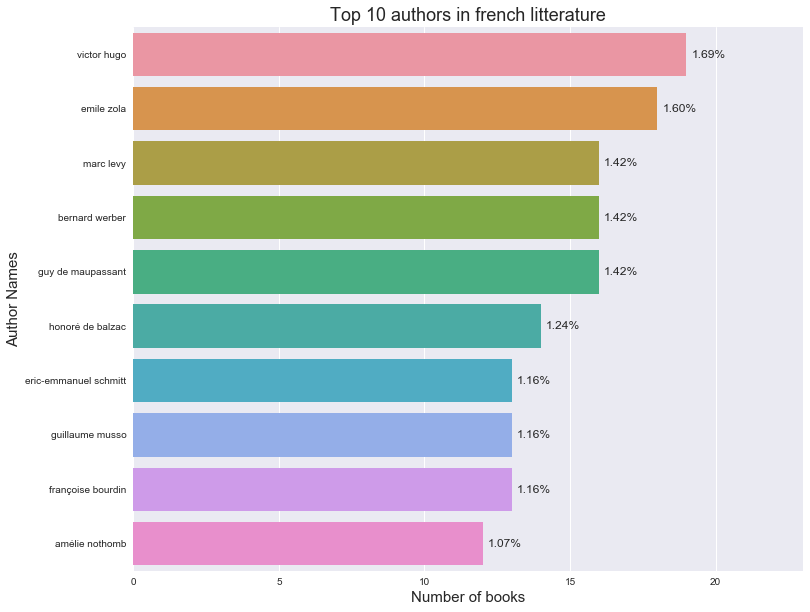

In [18]:
# Top 10 authors

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")
ax = sns.countplot(y = 'author_names',
              data = data,
              order = pd.value_counts(data['author_names']).iloc[:10].index)  # first 10 most frequently occurring values

for p in ax.patches:
    width = int(p.get_width()) # to get the width of the rectangles
    ax.annotate('{:.2f}%'.format((width/1125)*100), # to have percentage, we divide the number of value by total value(1125)
                ((p.get_x() + p.get_width()), p.get_y()), 
                xytext=(5, -25), # location of the text
                fontsize=12,
                textcoords='offset points') # place the annotations next to their respective bars

plt.xlim(0, 23)
plt.ylabel("Author Names", size = 15)
plt.xlabel("Number of books", size = 15)
plt.title('Top 10 authors in french litterature', size = 18)
plt.show()

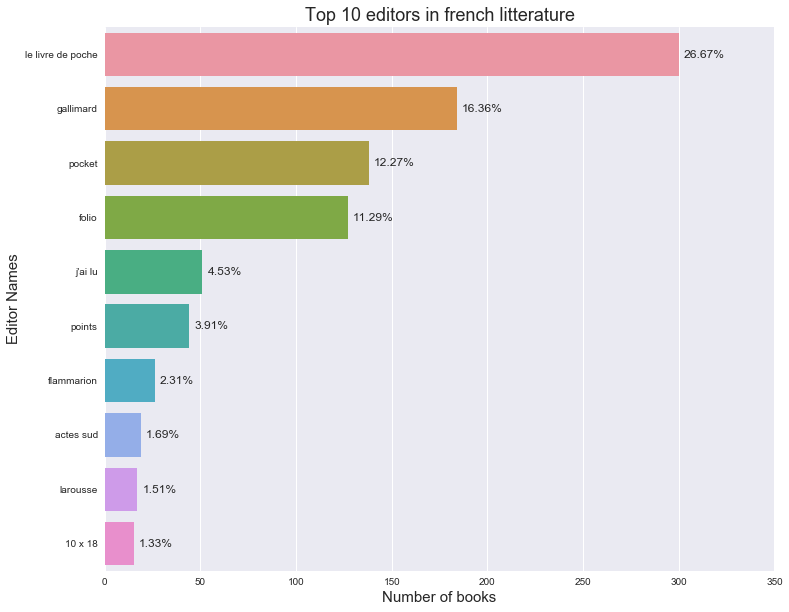

In [19]:
# Top 10 editors

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")
ax = sns.countplot(y = 'editor_names',
              data = data,
              order = pd.value_counts(data['editor_names']).iloc[:10].index) # first 10 most frequently occurring values

for p in ax.patches:
    width = int(p.get_width()) # to get the width of the rectangles
    ax.annotate('{:.2f}%'.format((width/1125)*100), # to have percentage, we divide the number of value by total value(1125)
                ((p.get_x() + p.get_width()), p.get_y()), 
                xytext=(5, -25), # location of the text
                fontsize=12,
                textcoords='offset points') # place the annotations next to their respective bars

plt.xlim(0, 350)
plt.ylabel("Editor Names", size = 15)
plt.xlabel("Number of books", size = 15)
plt.title('Top 10 editors in french litterature', size = 18)
plt.show()

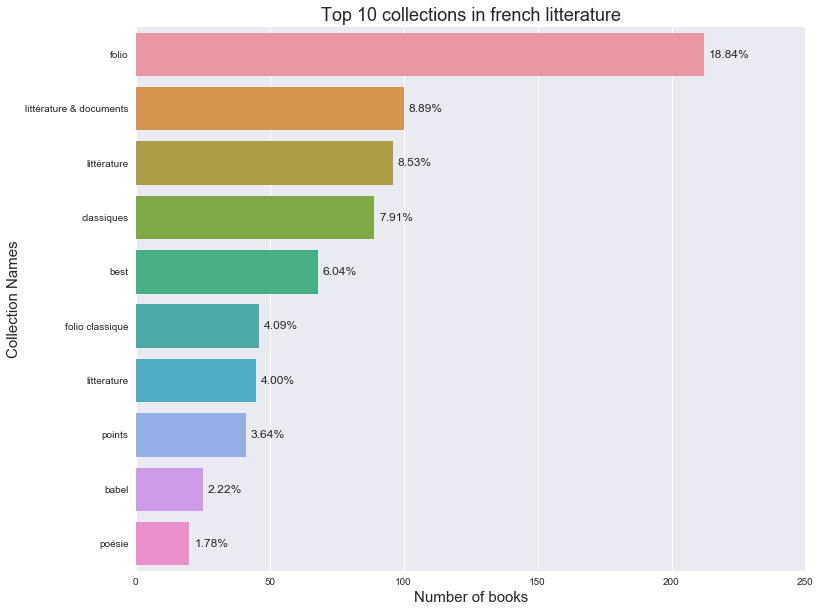

In [20]:
# Top 10 collections

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")
ax = sns.countplot(y = 'collections',
              data = data,
              order = pd.value_counts(data['collections']).iloc[:10].index) # first 10 most frequently occurring values

for p in ax.patches:
    width = int(p.get_width()) # to get the width of the rectangles
    ax.annotate('{:.2f}%'.format((width/1125)*100), # to have percentage, we divide the number of value by total value(1125)
                ((p.get_x() + p.get_width()), p.get_y()), 
                xytext=(5, -25), # location of the text
                fontsize=12,
                textcoords='offset points') # place the annotations next to their respective bars

plt.xlim(0, 250)
plt.ylabel("Collection Names", size = 15)
plt.xlabel("Number of books", size = 15)
plt.title('Top 10 collections in french litterature', size = 18)
plt.show()

### 4.2.3 Time variables

In [21]:
# extract year and month from datetime variable 
data['publication_year'] = data['publication_datetime'].dt.year # extract year from datetime variable 
data['publication_month'] = data['publication_datetime'].dt.month # extract month from datetime variable 

data.head()

,book_names,author_names,editor_names,collections,page_numbers,stars_counts,comments_counts,prices_new,publication_datetime,publication_year,publication_month
0,demain,guillaume musso,pocket,best,544,4.4,538,8.1,2017-01-05,2017,1
1,"désolée, je suis attendue",agnès martin-lugand,pocket,best,416,4.1,245,7.5,2017-04-06,2017,4
2,belle du seigneur,albert cohen,gallimard,folio,1109,4.1,115,12.6,1998-02-12,1998,2
3,tous les matins du monde,pascal quignard,gallimard,folio,116,3.9,28,6.6,1993-11-16,1993,11
4,la cicatrice,bruce lowery,j'ai lu,litterature generale,125,4.3,41,4.0,1999-10-21,1999,10


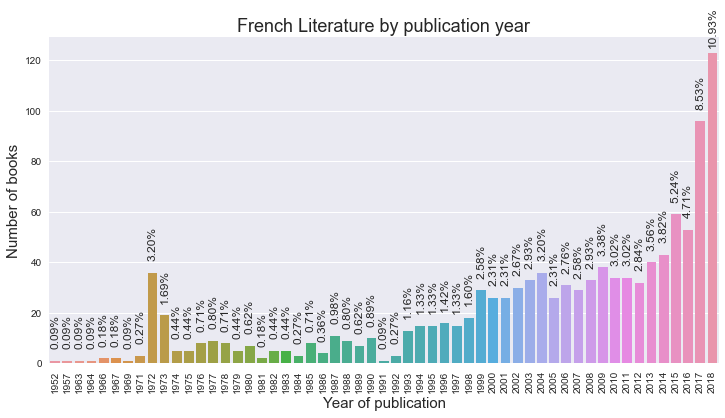

In [22]:
# Publication year

plt.figure(figsize=(12, 6))
ax = sns.countplot(x = 'publication_year',
                   data = data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 15, # alignment of the text
            '{:.2f}%'.format((height/1125)*100), # to have percentage, we divide the number of value by total value(1125)
            rotation=90, # rotate the text by 90 degree
            ha="center") # alignment of the text

plt.xlabel("Year of publication", size = 15)
plt.ylabel("Number of books", size = 15)
plt.xticks(rotation=90)
plt.title('French Literature by publication year', size = 18)
plt.show()

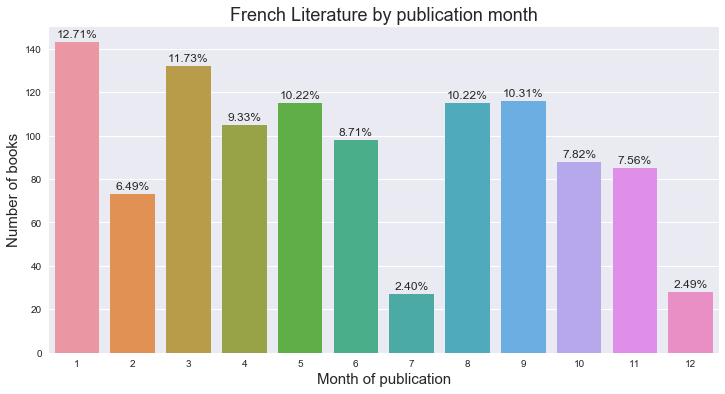

In [23]:
# Publication month

plt.figure(figsize=(12, 6))
ax = sns.countplot(x = 'publication_month',
                   data = data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2, # alignment of the text
            '{:.2f}%'.format((height/1125)*100), # to have percentage, we divide the number of value by total value(1125)
            ha="center") # alignment of the text

plt.xlabel("Month of publication", size = 15)
plt.ylabel("Number of books", size = 15)
plt.title('French Literature by publication month', size = 18)
plt.show()

## 4.3 Bivariate analysis - continuous X continuous 

### 4.3.1 Correlation 

In [27]:
#cont = ['page_numbers', 'prices_new', 'stars_counts', 'comments_counts']

print("Correlation between 'prices_new' and 'page_numbers': ", round(data['prices_new'].corr(data['page_numbers']), 2)) 
print("Correlation between 'prices_new' and 'stars_counts': ", round(data['prices_new'].corr(data['stars_counts']), 2)) 
print("Correlation between 'prices_new' and 'comments_counts': ", round(data['prices_new'].corr(data['comments_counts']), 2))


Correlation between 'prices_new' and 'page_numbers':  0.53
Correlation between 'prices_new' and 'stars_counts':  -0.16
Correlation between 'prices_new' and 'comments_counts':  0.03


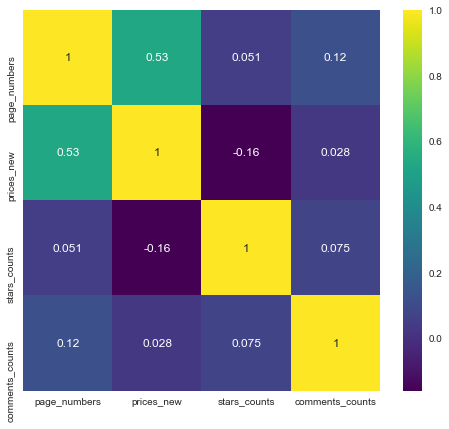

In [28]:
# heatmap

num_cols = pd.DataFrame(data = data, columns = cont)
corr = num_cols.corr()

fig, ax = plt.subplots(figsize=(8,7))    
sns.heatmap(corr, annot=True, cmap= "viridis", xticklabels= corr.columns, yticklabels= corr.columns, ax=ax)

### 4.3.2 Scatter plot 

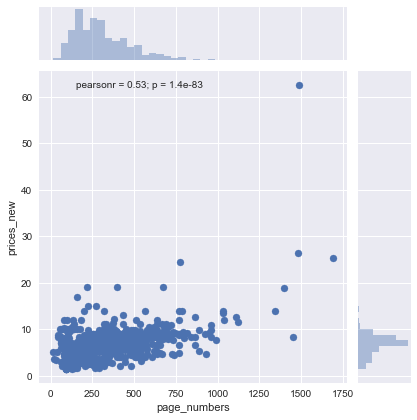

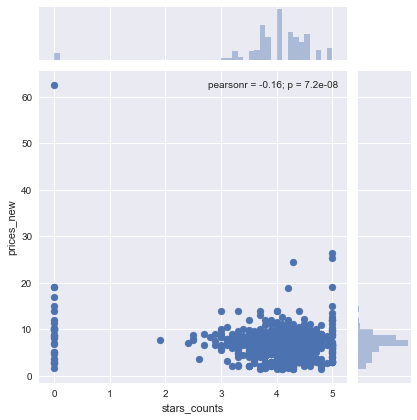

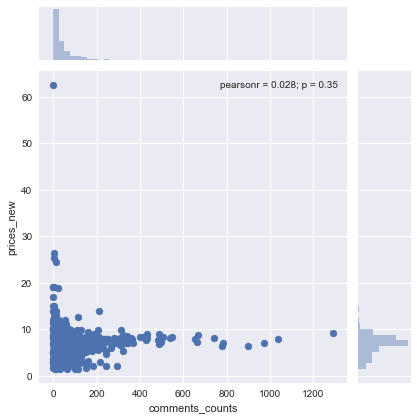

In [29]:
# jointplot 

sns.jointplot(x='page_numbers', y='prices_new', data= data) # correlation: 0.53
sns.jointplot(x='stars_counts', y='prices_new', data=data) # correlation: -0.16
sns.jointplot(x='comments_counts', y='prices_new', data=data) # correlation: 0.028

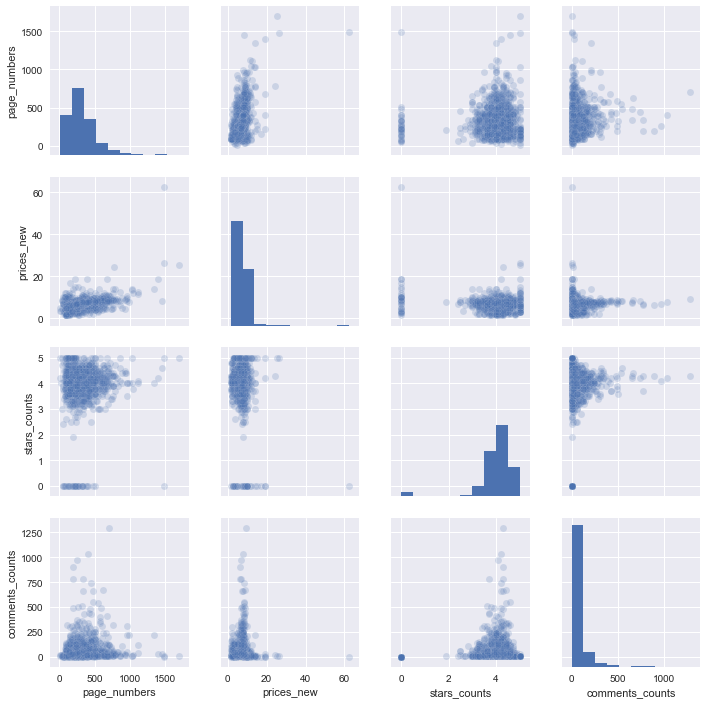

In [30]:
# pairplot

sns.pairplot(data, size=2.5, vars=cont, plot_kws = {'alpha': 0.2}) # alpha to set the level of transparency 
plt.show()

## 4.4 Bivariate analysis - continuous X category

### 4.4.1 Boxplot

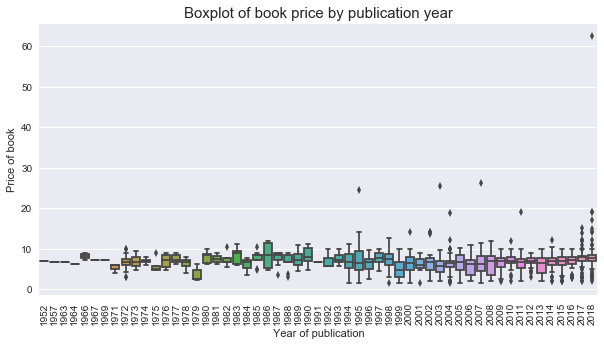

In [31]:
# Boxplot of book price by publication year

plt.figure(figsize=(10, 5))
sns.boxplot(x=data['publication_year'], y=data['prices_new'])
plt.xlabel("Year of publication")
plt.ylabel("Price of book")
plt.xticks(rotation=90)
plt.title("Boxplot of book price by publication year", size = 15)
plt.show()

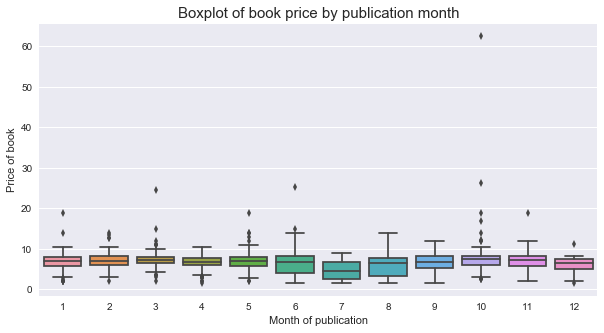

In [32]:
# Boxplot of book price by publication month

plt.figure(figsize=(10, 5))
sns.boxplot(x=data['publication_month'], y=data['prices_new'])
plt.xlabel("Month of publication")
plt.ylabel("Price of book")
plt.title("Boxplot of book price by publication month", size = 15)
plt.show()

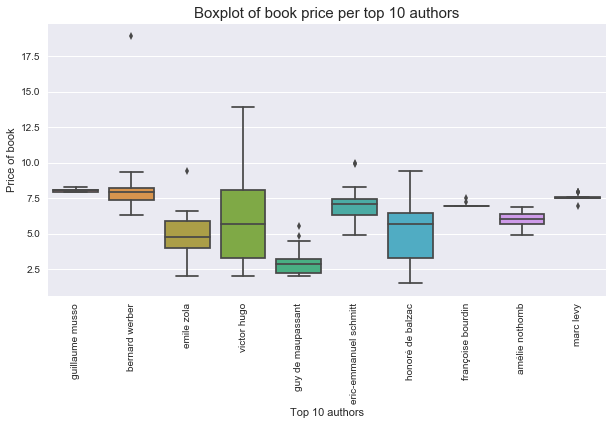

In [33]:
# Boxplot of book price per top 10 authors

# Create a new dataframe only with top 10 authors 
top10_authors = pd.value_counts(data['author_names']).iloc[:10].keys().tolist()
df_top10_authors = data[data['author_names'].isin(top10_authors)]

# Draw a boxplot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_top10_authors['author_names'], y=df_top10_authors['prices_new'])
plt.xlabel("Top 10 authors")
plt.ylabel("Price of book")
plt.xticks(rotation=90)
plt.title("Boxplot of book price per top 10 authors", size = 15)
plt.show()

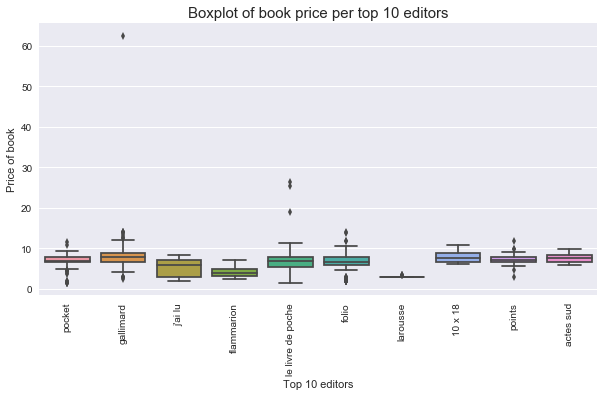

In [34]:
# Boxplot of book price per top 10 editors

# Create a new dataframe only with top 10 editors
top10_editors = pd.value_counts(data['editor_names']).iloc[:10].keys().tolist()
df_top10_editors = data[data['editor_names'].isin(top10_editors)]

# Draw a boxplot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_top10_editors['editor_names'], y=df_top10_editors['prices_new'])
plt.xlabel("Top 10 editors")
plt.ylabel("Price of book")
plt.xticks(rotation=90)
plt.title("Boxplot of book price per top 10 editors", size = 15)
plt.show()

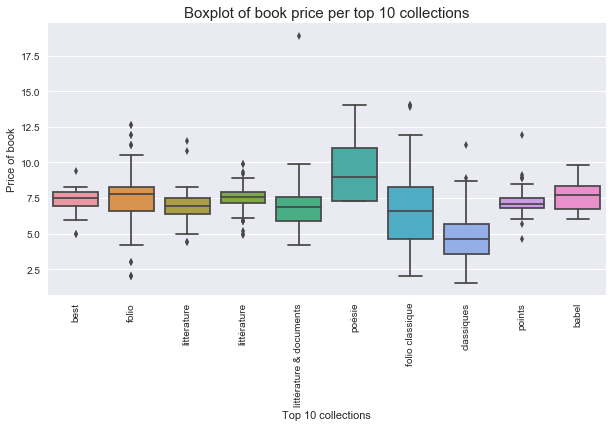

In [35]:
# Boxplot of book price per top 10 collections

# Create a new dataframe only with top 10 collections
top10_collections = pd.value_counts(data['collections']).iloc[:10].keys().tolist()
df_top10_collections = data[data['collections'].isin(top10_collections)]

# Draw a boxplot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_top10_collections['collections'], y=df_top10_editors['prices_new'])
plt.xlabel("Top 10 collections")
plt.ylabel("Price of book")
plt.xticks(rotation=90)
plt.title("Boxplot of book price per top 10 collections", size = 15)
plt.show()

## 4.5 Time series plot 

In [24]:
# 1. Extract books from last 10 years (2009-2018) 
# Since the range of the publication years is too wide, we only take a look the books which are published after year 2008 
last_10_years = data.loc[(data['publication_datetime'].dt.year > 2008)] 
last_10_years.info() # 552 row are selected (49%)

# 2. Set 'publication_datetime' as index for time series plot
last_10_years.set_index('publication_datetime', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 1124
Data columns (total 11 columns):
book_names              552 non-null object
author_names            552 non-null object
editor_names            552 non-null object
collections             552 non-null object
page_numbers            552 non-null int64
stars_counts            552 non-null float64
comments_counts         552 non-null int64
prices_new              552 non-null float64
publication_datetime    552 non-null datetime64[ns]
publication_year        552 non-null int64
publication_month       552 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 51.8+ KB


Text(0.5,1,'Page Numbers Trend over Time')

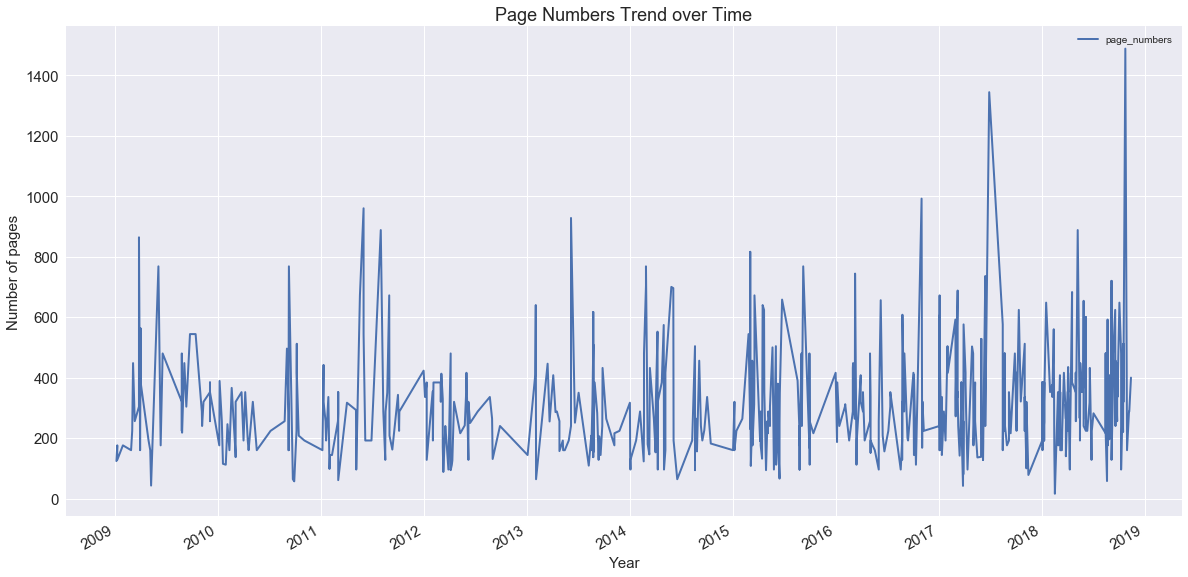

In [25]:
# Time series visualization - page_numbers

last_10_years[['page_numbers']].plot(figsize=(20,10), linewidth=2, fontsize=15)
plt.xlabel('Year', size = 15)
plt.ylabel('Number of pages', size = 15)
plt.title('Page Numbers Trend over Time', size = 18)

Text(0.5,1,'Price Trend over Time')

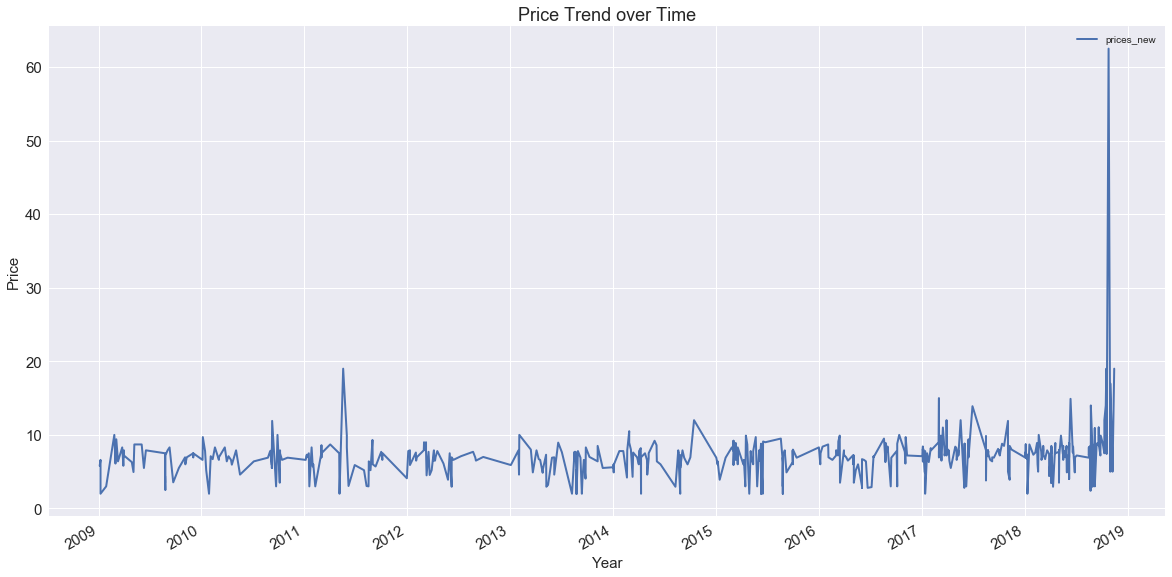

In [26]:
# Time series visualization - prices_new

last_10_years[['prices_new']].plot(figsize=(20,10), linewidth=2, fontsize=15)
plt.xlabel('Year', size = 15)
plt.ylabel('Price', size = 15)
plt.title('Price Trend over Time', size = 18)

## 4.6 Simple Linear Regression 

In [36]:
X = data["page_numbers"] # choose the variable which has the highest correlation
y = data["prices_new"]

model = sm.OLS(y, X)
results = model.fit() # make a regression model with X and y

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prices_new   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     4358.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:44:25   Log-Likelihood:                -2971.6
No. Observations:                1125   AIC:                             5945.
Df Residuals:                    1124   BIC:                             5950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
page_numbers     0.0177      0.000     66.015      0.000       0.017       0.018
==============================================================================
Omnibus:                      334.843   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10539.288
Skew:                           0.712   Prob(JB):                         0.00
Kurtosis:                      17.927   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

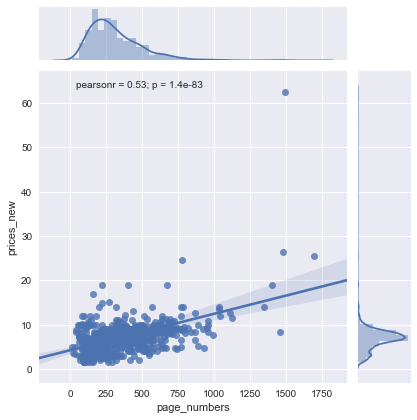

In [37]:
# Visualization

sns.jointplot(x='page_numbers', y='prices_new', data= data, kind="reg") 